# Facial Detection Using Machine Learning Techniques - Intro

## Project Overview

This Jupyter Notebook presents an implementation of a face detection system using traditional Machine Learning techniques. Although deep learning-based approaches have become more prominent in recent years, the earlier methods retain their relevance due to their computational efficiency and robustness. A prime example of such an approach is the Viola-Jones face detector.

The purpose of this project is to build face detectors from classifiers. Instead of directly working with pixels, we'll use features extracted from the images. Our main goal is to develop computationally light classifiers capable of determining whether a given image is a face.

The project follows the following steps:

1. **Preprocessing**: Define the initial treatment of images, such as normalization, scaling, and application of general transformations.
2. **Features**: Define the process of extracting Haar features and building the feature matrix.
3. **Classifiers**: Implement classification algorithms seen in the course, including ensemble techniques.
4. **Model Evaluation**: Evaluate different classifiers using validation and evaluation techniques seen in the course.
5. **Attentional Cascade**: Implement the cascading classification mechanism.

## Dataset

The dataset consists of grayscale images, with pixel values ranging from 0 (black) to 255 (white). Of the `N` images, `p` are faces (positive examples) and `n` are backgrounds (negative examples).


# Setting Up the Environment using Conda

## Pre-requisites

1. **Python:** This project is written in Python, an interpreted high-level general-purpose programming language. Python must be installed on your machine. You can verify if Python is installed by typing `python --version` into your terminal. If Python is installed, this command should return a version number.

2. **Conda:** Conda is an open-source package management system and environment management system. You should have Conda installed on your machine. To confirm, type `conda --version` in your terminal. If Conda is installed, this command will return a version number.

If Python or Conda are not installed on your machine, you can download them from the [official Python website](https://www.python.org/) and [official Anaconda website](https://www.anaconda.com/products/distribution) respectively.

## Conda Environment

After ensuring that Python and Conda are installed, create a virtual environment for the project.

1. **Create the environment**: We have provided an `environment.yml` file which contains a list of all the Python packages needed for the project. To create a new environment using this file, use the following command:

```bash
conda env create -f environment.yml
```

2. **Activate the environment**: After the new environment has been created, activate it with:

```bash
conda activate face_detection
```



In [1]:
from tqdm import tqdm
import os

import random

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# setting seed for reproducibility
SEED = 34
random.seed(SEED)
np.random.seed(SEED)

# Introduction
In this Jupyter notebook, we will embark on the first step of our Face Detection project: loading and exploring the dataset. This initial phase is crucial as it helps us to understand the data we're working with and to inform the subsequent steps in our machine learning workflow.

The dataset consists of grayscale images, representing both faces (positive examples) and non-faces (negative examples). The positive examples are images of faces, while the negative examples are images taken from scenes that contain everything but faces. The images are all of the same size, and the faces in the positive examples are aligned and scaled to fit the images.

# Loading the Dataset
We will start by loading the dataset. The images are stored in a [pgm format](https://netpbm.sourceforge.net/doc/pgm.html), which is a simple format for grayscale images.

In [3]:
TRAIN_FACES_DIR = "data/train/face/"
TRAIN_BACKGROUND_DIR = "data/train/non-face/"
TEST_FACES_DIR = "data/test/face/"
TEST_BACKGROUND_DIR = "data/test/non-face/"


def load_name_images(directory):
    return [f for f in os.listdir(directory) if f.endswith('.pgm')]


# Load the dataset
train_faces = load_name_images(TRAIN_FACES_DIR)
train_background = load_name_images(TRAIN_BACKGROUND_DIR)
test_faces = load_name_images(TEST_FACES_DIR)
test_background = load_name_images(TEST_BACKGROUND_DIR)

# Exploratory Data Analysis
After loading the data, we will perform an exploratory data analysis (EDA). This is where we examine the data, look for anomalies, study its structure, and visualize it through various kinds of plots. The goal of this stage is to find patterns, spot anomalies, or check assumptions with the help of summary statistics and graphical representations.

The following tasks will be performed during the EDA:

1. **Viewing the images**: We will view some of the face and non-face images to get an idea of what our data looks like.

2. **Checking the balance of the dataset**: It is crucial to know if the data is balanced or imbalanced. If the data is imbalanced, it might impact the performance of our machine learning model, and we'll need to address this.

3. **Basic Statistics**: We'll calculate some basic statistics to get a better sense of our data.

This initial exploration will help us get familiar with the dataset and gain valuable insights that will guide us in the rest of the project.

## Viewing the Images
Let's start by viewing some of the images in our dataset. We'll use the `imshow()` and `imread()` functions from the `matplotlib` library to load and display the images.

In [4]:
def load_images(directory, names):
    return [plt.imread(directory + name) for name in tqdm(names, desc='Loading images from ' + directory)]

# Load the trining images
train_faces_images = load_images(TRAIN_FACES_DIR, train_faces)
train_background_images = load_images(TRAIN_BACKGROUND_DIR, train_background)

# Create the training set
X_train = np.array(train_faces_images + train_background_images)
# Create the labels (1 for faces, 0 for non-faces)
y_train = np.array([1] * len(train_faces_images) + [0] * len(train_background_images))

# Load the test images
test_faces_images = load_images(TEST_FACES_DIR, test_faces)
test_background_images = load_images(TEST_BACKGROUND_DIR, test_background)

# Create the test set
X_test = np.array(test_faces_images + test_background_images)
# Create the labels (1 for faces, 0 for non-faces)
y_test = np.array([1] * len(test_faces_images) + [0] * len(test_background_images))

Loading images from data/test/non-face/: 100%|██████████| 23573/23573 [00:01<00:00, 23017.87it/s]


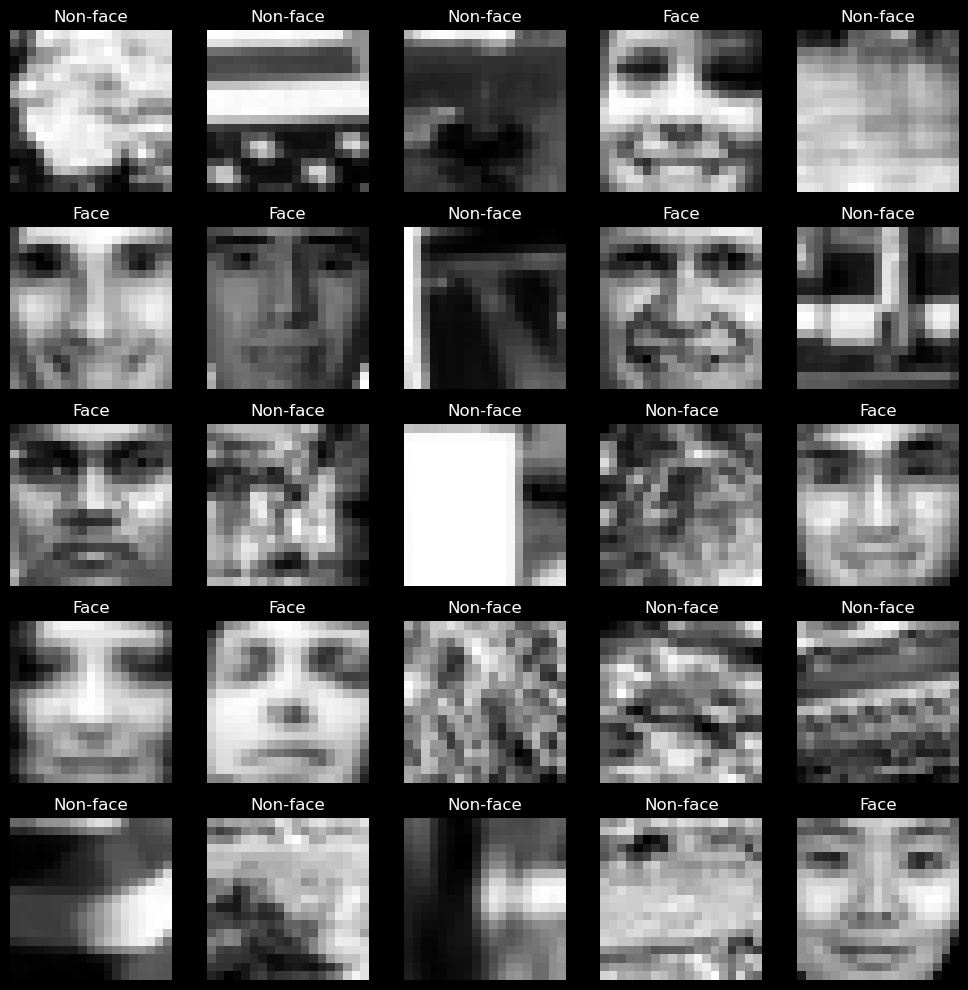

In [5]:
def plot_image(images, labels):
    # select 25 random images
    random_indices = np.random.choice(images.shape[0], size=25, replace=False)
    random_images = images[random_indices]
    random_labels = labels[random_indices]

    # plot the 25 random images, with their labels
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(random_images[i], cmap='gray')
        
        ax.set_title('Face' if random_labels[i] else 'Non-face')
        
        ax.axis('off')

    plt.tight_layout()

    plt.show()

np.random.seed(SEED)
# Plot the training set
plot_image(X_train, y_train)

## Checking the Balance of the Dataset

Before proceeding with modeling, it's crucial to examine the balance of our dataset. A balanced dataset refers to one where the number of samples in each class are approximately equal. If our dataset is severely imbalanced, it might negatively impact the performance of our model, leading it to be biased towards the majority class.

In the context of our face detection task, we need to ensure that we have an approximately equal number of face and non-face images. This step will ensure that our model gets enough exposure to both classes during training, leading to a more robust and generalizable model.

Let's perform a check on our dataset to see how well balanced it is.


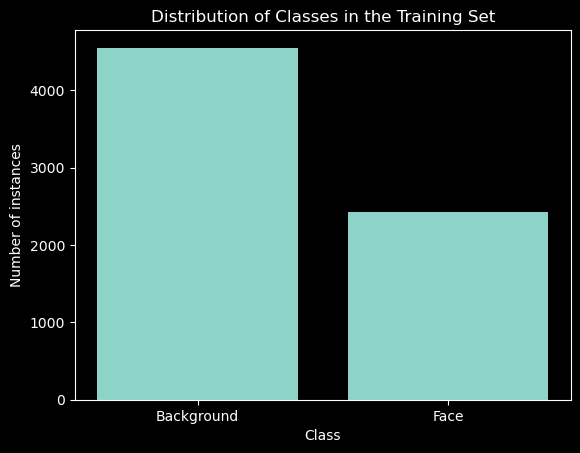

In [6]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the number of each class
counter = Counter(y_train)

# Create a bar chart
plt.bar(counter.keys(), counter.values())
plt.title("Distribution of Classes in the Training Set")
plt.xlabel("Class")
plt.ylabel("Number of instances")
plt.xticks(list(counter.keys()), ['Face', 'Background'])
plt.show()

In [7]:
face_percentage = (len(train_faces_images) / len(X_train)) * 100

print(f"Percentage of faces in the training set: {face_percentage:.2f}%")

Percentage of faces in the training set: 34.81%


Our dataset presents a mild imbalance, with 34.81% of the images being faces. This is not a severe imbalance, and we can proceed with the modeling step. Also, in next steps, we will use techniques to address this imbalance like use evaluation metrics that are robust to imbalanced datasets.

## Basic Statistics

In the context of our face detection task, understanding the distribution of pixel values across our images can provide valuable insights for preprocessing steps and overall algorithm improvement. 

In grayscale images, pixel values range from 0 (black) to 255 (white). By analyzing these values, we can obtain information about aspects such as image brightness and contrast which are crucial for effective feature extraction and object detection.

We can calculate a histogram to visualize the frequency distribution of pixel values. This, along with descriptive statistics such as mean, median, and standard deviation, can guide us towards appropriate preprocessing methods, for instance, brightness and contrast adjustments.

Let's now proceed to analyze the distribution of pixel values in our dataset.



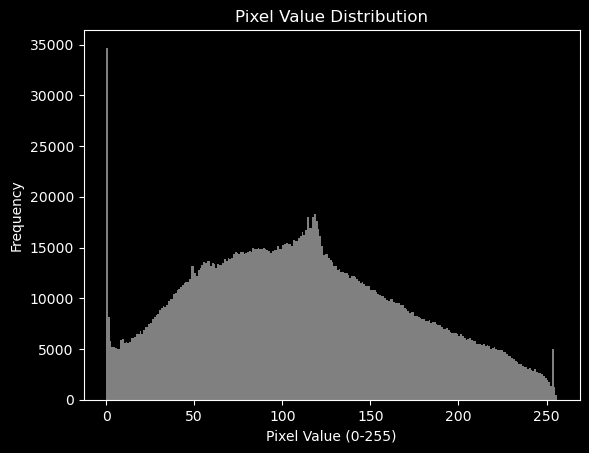

Mean pixel value: 110.51405587889293
Median pixel value: 107.0
Standard Deviation of pixel values: 60.30700268765547


In [8]:
def basic_stats(images, range=(0,256)): 
    # Flatten the array to 1D for histogram and statistics
    pixels = images.flatten()

    # Generate histogram
    plt.hist(pixels, bins=256, range=range, color='gray')
    plt.title('Pixel Value Distribution')
    plt.xlabel('Pixel Value (0-255)')
    plt.ylabel('Frequency')
    plt.show()

    # Calculate and print basic statistics
    mean_value = np.mean(pixels)
    median_value = np.median(pixels)
    std_dev = np.std(pixels)

    print(f'Mean pixel value: {mean_value}')
    print(f'Median pixel value: {median_value}')
    print(f'Standard Deviation of pixel values: {std_dev}')

basic_stats(X_train)

In reviewing the statistics and visualizations of our dataset, there are several key conclusions we can draw:

- **Histogram**: The distribution of pixel values across the entire range, with a clear concentration in the middle, suggests that our images generally have good contrast and range of pixel intensities. However, the majority of pixels fall within medium-intensity levels, suggesting that our images are generally neither too dark nor too light. Additionally, there is a significant spike at the value of 0, corresponding to white pixels. This is likely due to color truncation by the camera sensors, which often struggle to capture detail in extremely bright areas, leading to these areas being recorded as pure white.

- **Mean and Median**: The close proximity of the mean and median indicates that the pixel intensity distribution is fairly symmetrical without significant outliers skewing the mean. This is a positive sign, suggesting that outlier values within our data may not be a significant concern.

- **Standard Deviation**: A standard deviation of approximately 60 is relatively high, indicating a substantial amount of variation in the pixel values across our images. This means that our images span a wide range of pixel intensities, from dark to light. This could potentially benefit our facial recognition classifier, as it implies that our model will have the opportunity to learn to recognize faces across various lighting conditions.

Even with these insights, we are planning to perform equalization as a part of preprocessing, which would help to distribute pixel intensities across the full range more evenly, potentially enhancing the contrast and details within the images. 

After applying the equalization, we will reassess these statistics to ensure that our preprocessing has had the desired effect and that our data is in a suitable state for model training. 



# Image Preprocessing

Image preprocessing is a critical step in computer vision tasks. Proper preprocessing can significantly improve the performance of your models by making the raw input data more suitable for analysis.

The primary aim of preprocessing in our project is to standardize the images, enhancing the contrast and bringing out the relevant features more prominently. This step becomes especially important when working with grayscale images as in our case, where contrast plays a crucial role in feature detection.


## Histogram Equalization

One of the preprocessing techniques we will be using is [Histogram Equalization](https://en.wikipedia.org/wiki/Histogram_equalization). Histogram Equalization is a method that improves the contrast in an image, in order to stretch out the intensity range. It does so by effectively spreading out the most frequent intensity values, i.e., enhancing the contrast where there are a lot of close intensity values. This method is useful when an image contains foregrounds and backgrounds that both are bright or both are dark.

The function `equalize_hist` from `skimage.exposure` module will be used for this purpose. This function equalizes the image histogram, which flattens the grayscale histogram of the image, enhancing the contrast.

Let's proceed with the preprocessing.

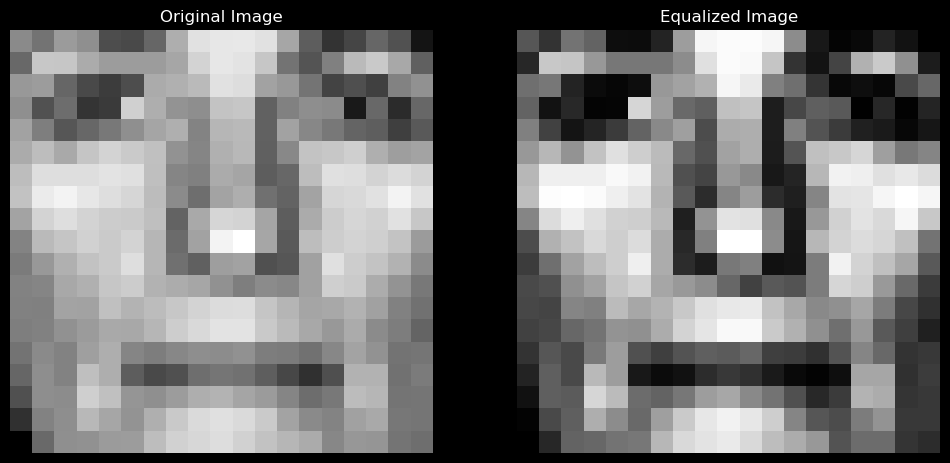

In [45]:
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist

# Choose an image to transform
image_index = 1269

# Equalize histogram
original_image = X_train[image_index]
image_equalized = equalize_hist(original_image)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display original image
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Display image after histogram equalization
ax[1].imshow(image_equalized, cmap='gray')
ax[1].set_title('Equalized Image')
ax[1].axis('off')

plt.show()

In [9]:
# Equalize the training and test sets
X_train_norm = np.array([equalize_hist(image) for image in X_train])
X_test_norm = np.array([equalize_hist(image) for image in X_test])

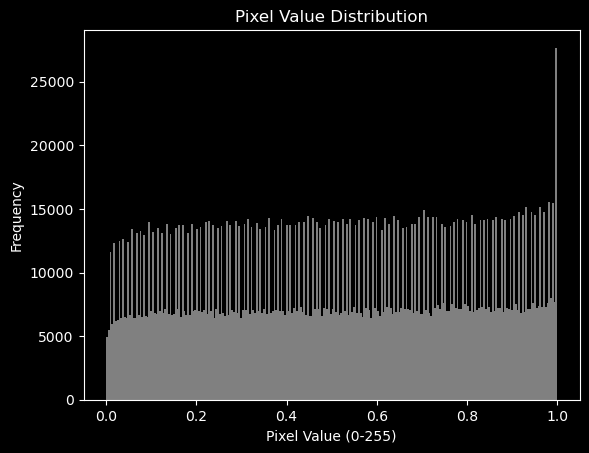

Mean pixel value: 0.513432912449607
Median pixel value: 0.5152354570637119
Standard Deviation of pixel values: 0.2892390351970039


In [10]:
basic_stats(X_train_norm, range=(0,1))

Upon applying the histogram equalization to our images, we can observe a noticeable shift in the image's histogram. The pixel intensity distribution is now spread out evenly across the entire range (from 0 to 1). This indicates that the contrast of the image has been enhanced and that the details within different intensity regions are now more discernible. This procedure will be beneficial to our model training as it can help our model better recognize features in different intensity regions. We will apply this equalization process to all the images in our dataset during the preprocessing phase.


## Resizing

Images in a dataset can come in different sizes and resolutions. However, machine learning models often require a fixed input size, which means we usually need to resize our images to have the same width and height before feeding them into the model. 

To approach this, the first step will be to verify the sizes of our images in the current dataset to understand better what we're dealing with. It's crucial to check whether all our images have the same dimensions. If that's the case, we might not need to do any resizing. 

Let's go ahead and check the sizes of our images.


In [46]:
image_sizes = [img.shape for img in X_train_norm]

# Check if all images have the same size
if len(set(image_sizes)) == 1:
    print(f"All images have the same size: {image_sizes[0]}")
else:
    print(f"Images have varying sizes. Here are some examples: {image_sizes[:5]}")


All images have the same size: (19, 19)


We have verified that all images in our dataset have a consistent size of 19x19 pixels. This uniformity is advantageous, as it eliminates the need for potentially distorting resize operations.

Given that all our images are already of the same dimensions, and the dimension size is relatively small, we have decided not to perform any resizing on our images during the training process. The reasoning behind this decision is to retain as much of the original image information as possible and prevent potential distortions or loss of details that could arise from resizing.
